In [8]:
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.stats import smetrics
# from preproc_tools import get_fr_by_sample
import numpy as np
import compute_population_distance
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from ephysvibe.stats import smetrics

### Start preprocessing

In [3]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5",
  'nidpath': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 100,
    'min_sp_sec' : 1,
    'norm' : False,
    'zscore' : True,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,}

In [4]:
res = compute_population_distance.compute_distance(**preprocessing, **paths)

Compute distances


100%|██████████| 530/530 [00:05<00:00, 99.40it/s] 


start iterations


100%|██████████| 1000/1000 [02:07<00:00,  7.87it/s]


In [5]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p

In [6]:
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

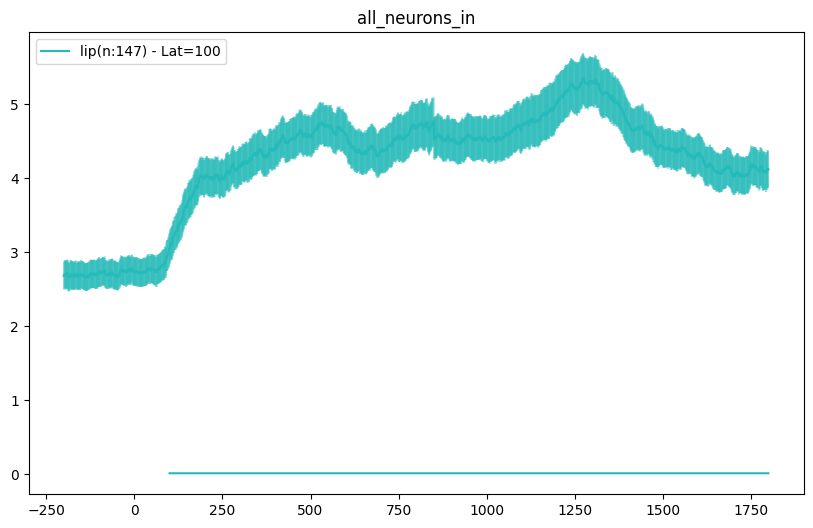

In [9]:
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip']):
    d=res.distance['dist_n_nn']
    fd=res.distance['dist_fake_n_nn']

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('all_neurons_in')